<a href="https://colab.research.google.com/github/gogosean/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
test
# and reproducing what it is to look up and learn things

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

All passed!


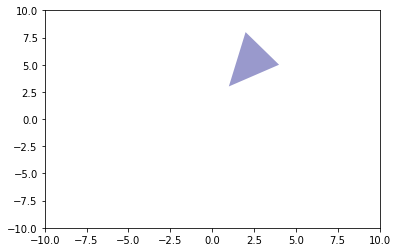

In [2]:
# TODO - your code here
def palindrome(string):
    """Check if input string (all lower-case characters) is a palindrome."""
    for i in range(len(string)//2):
        if string[i] != string[len(string)-i-1]:
            return False
    return True
    
assert palindrome('') == True
assert palindrome('a') == True
assert palindrome('ab') == False
assert palindrome('abba') == True
assert palindrome('redivider') == True
print('All passed!')
# Use what we did live in lecture as an example
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import seaborn as sns

def line(x,y=[0,0],mode='line'):
    
    '''
    USE:    geo([2,10]) 
   
    '''
    sns.set_context('notebook')
    plt.style.use('seaborn-bright')

    fig = plt.figure()
    
    ax = fig.add_subplot(111)
    line = Line2D(x, y)
    ax.add_line(line)
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)

    plt.grid(b=True, which='major', color='grey', linestyle='--')
    plt.grid(b=True, which='minor', color='grey', linestyle='-', alpha=0.1)
    plt.minorticks_on()
    plt.show()

    plt.show()
    
def poly(xyz):
    
    '''
    USE: poly([[2,8],[1,3],[4,5]])
    '''
    
    fig, ax = plt.subplots()
    patches = []

    polygon = Polygon(xyz, True)
    patches.append(polygon)

    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)

    colors = 100*np.random.rand(len(patches))
    p.set_array(np.array(colors))
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)

    ax.add_collection(p)

    plt.show()
    
poly([[2,8],[1,3],[4,5]])

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

**This looks for a palindrome. It works by comparing the first and last letters of a word and then sees if they are equal. it then moves on to the second letter and the next to the last letter and so on and so forth. The graph creates a simple polygon and fills it. I did this to find interesting plotting examples**

2.  What was the most challenging part of what you did?
**coming up with the solution of my own, but could not.**

3.  What was the most interesting thing you learned?
**this is a simple solution so i should not have overcomplicated it**

4.  What area would you like to explore with more time?
**This uses the assert command in the first example, which is used in error trapping so i should learn more about that.**




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.